# Threshold, RBF and PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import gitInformation
from neo.io import NeuralynxIO
import quantities as pq
import sklearn

In [2]:
% matplotlib inline

In [3]:
gitInformation.printInformation()

Information about this notebook
Date: 2016-01-05
Python Version: 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 16:44:52) [MSC v.1500 64 bit (AMD64)]
Git directory: C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\.git
Current git SHA: aa3853e0374225c26d947dd83698e78c9c013954
Remotes: fork, origin, 
Current branch: master
fork remote URL: http://github.com/dowa4213/kt-2015-DSPHandsOn.git
origin remote URL: https://github.com/ktakagaki/kt-2015-DSPHandsOn.git


In [4]:
sessionfolder = 'C:\\Users\\Dominik\\Documents\\GitRep\\kt-2015-DSPHandsOn\\MedianFilter\\Python\\07. Real Data'

In [5]:
NIO = NeuralynxIO(sessiondir = sessionfolder, cachedir = sessionfolder)
block = NIO.read_block()
seg = block.segments[0]
analogsignal = seg.analogsignalarrays[0]

In [6]:
csc = analogsignal.magnitude

In [7]:
type(csc)

numpy.ndarray

In [8]:
csc.shape

(3142144L,)

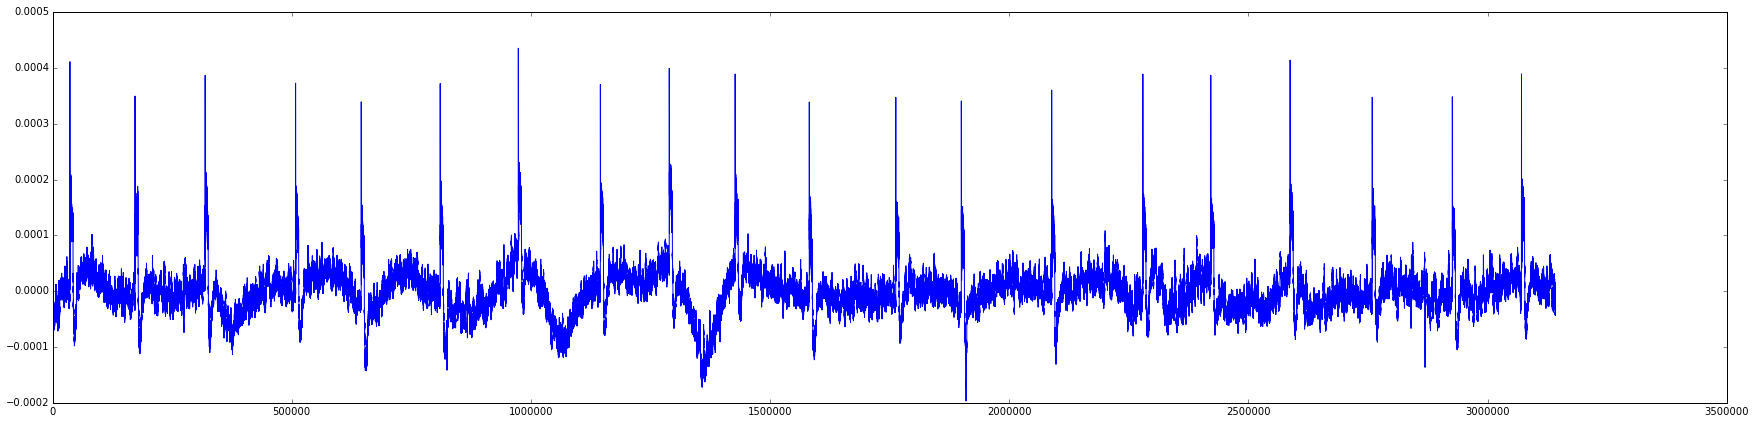

In [9]:
plt.figure(figsize=(30,7))
plt.plot(csc)

In [10]:
filtered = medfilt(csc,45)
new_data = csc-filtered

In [11]:
8*np.median(abs(new_data)/0.6745)

2.1356170351299873e-05

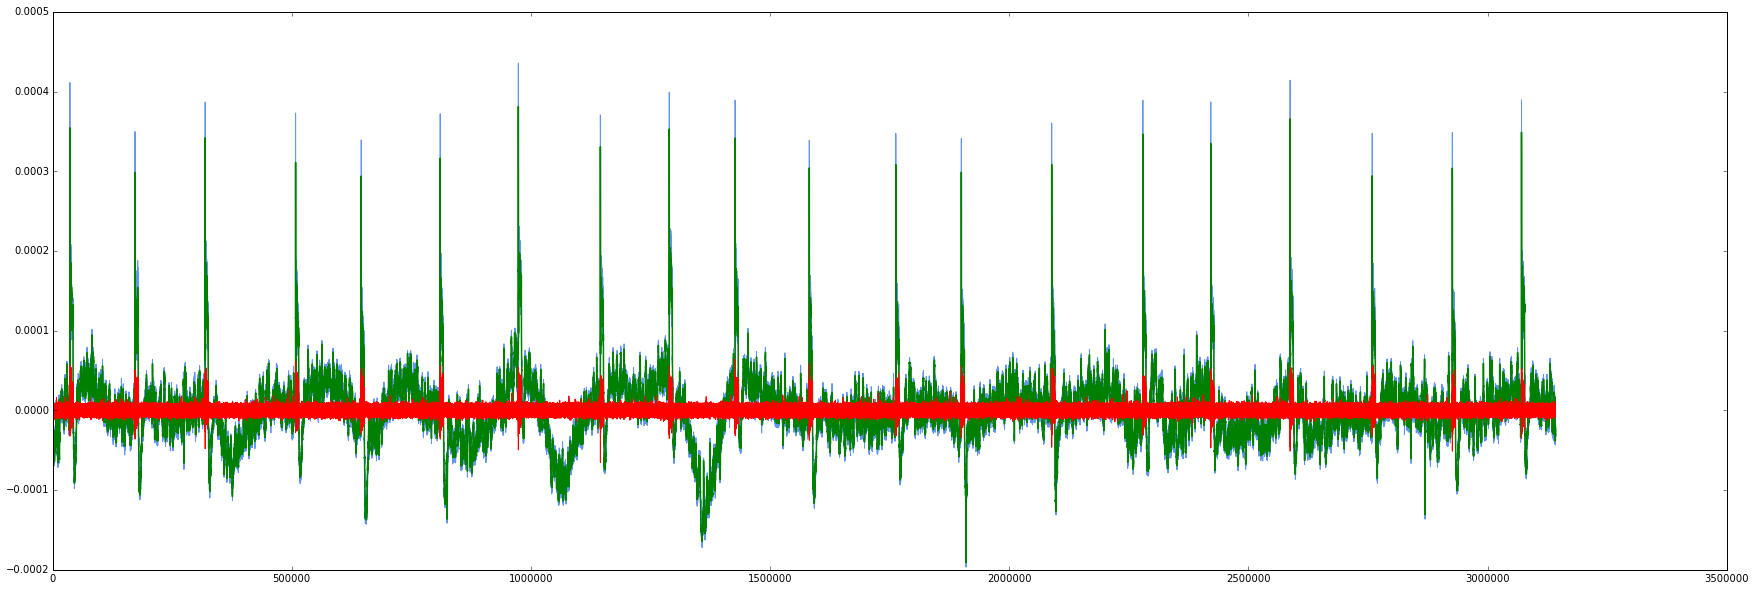

In [12]:
plt.figure(figsize=(30,10))
plt.plot(csc, color = 'cornflowerblue')
plt.plot(filtered, color = 'g', lw = 1.5)
plt.plot(new_data, color = 'r')

In [13]:
# Declaring counter and and dead time.
# Dead time: if the threshold is reached, we wait 50 samples until the threshhold can be
# activated again
count  = -1
count2 = 0
timer = 0
# Dictionary with all thresholded shapes
thresholds = {}
# Get the value in the new_data array:
for i in new_data:
    # Increment the counter (counter = position in the array)
    count += 1
    # if the value is bigger then 0.0002, the threshold is reached
    if i >= 0.000021:
        # check the thresholded window if some values are bigger then 0.00005, or smaller then -0.000025.
        temp = [i for i in new_data[count -6 : count + 18] if i >= 0.00005] #or i <= - 0.000025]
        # If no values are bigger then 0.000045 and the dead time is zero,
        # save the window in the dictionary 
        if len(temp) == 0 and timer == 0:
            # set the timer to 20, so 20 samples will be passed
            timer = 16
            # increment count2, for the array name
            count2 += 1
            thresholds["spike{0}".format(count2)] = new_data[count -6 : count + 18]
    elif timer > 0: 
        # Decrement the timer.
        timer -= 1
    else: 
        pass

In [14]:
# Transfrom the thresholded shpaes into a array
thresholds_array = np.zeros((24,len(thresholds)))
count = -1
for o in thresholds:
    count += 1
    thresholds_array[:,count] = thresholds[o]

In [15]:
from scipy.interpolate import Rbf

In [16]:
x = np.arange(24)
x_new = np.linspace(0,24,240)
#Interpolate each spike with a Cubic RBF function
thresholds_interp = np.zeros((len(x_new),len(thresholds_array[1,:])))
for o in range(len(thresholds_array[1,:])):
    newfunc = Rbf(x, thresholds_array[:,o], function = 'cubic')
    thresholds_interp[:,o] = newfunc(x_new)

In [17]:
thresholds_norm = thresholds_interp/float(thresholds_interp.max())

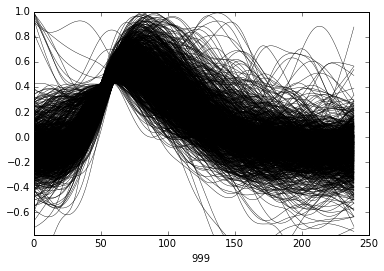

In [18]:
count = -1
for o in range(len(thresholds_interp[0,:])):
    count += 1
    #fig = plt.figure(o)
    plt.axis([0,250,-0.78, 1.0])
    plt.plot( thresholds_norm[:,o], color = 'black', linewidth = 0.4)
    plt.xlabel(str(count))

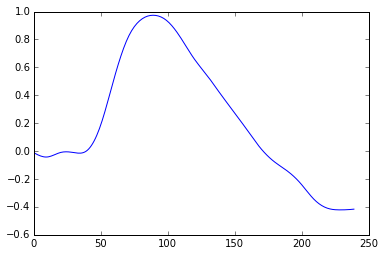

In [19]:
plt.plot(thresholds_norm[:,182])

In [20]:
template1 = thresholds_norm[:,29]
template2 = thresholds_norm[:,31]
template3 = thresholds_norm[:,75]
template4 = thresholds_norm[:,124]
template5 = thresholds_norm[:,175]
template6 = thresholds_norm[:,182]

In [21]:

templates = np.zeros((6,240))

1


C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

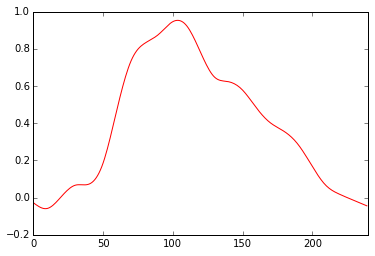

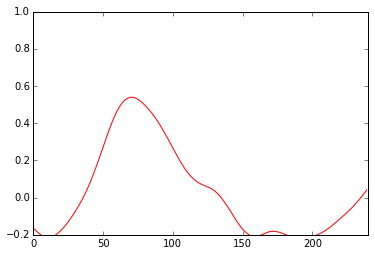

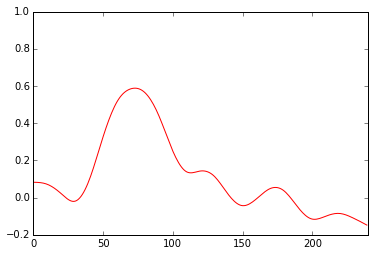

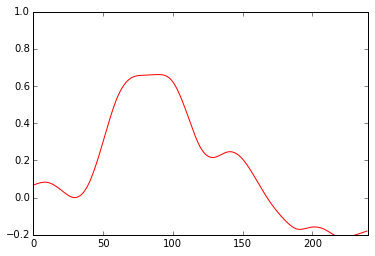

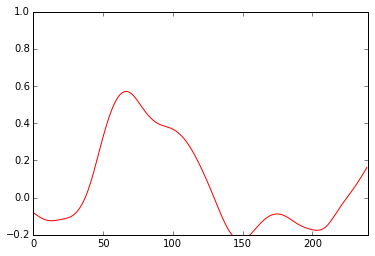

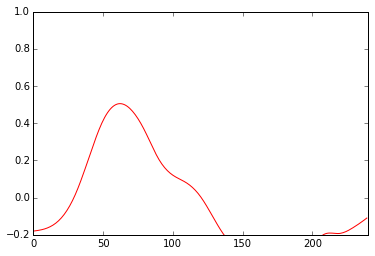

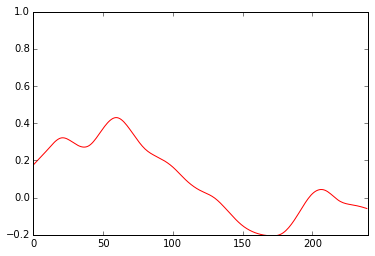

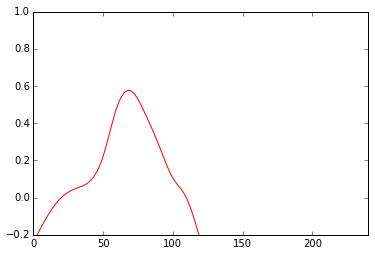

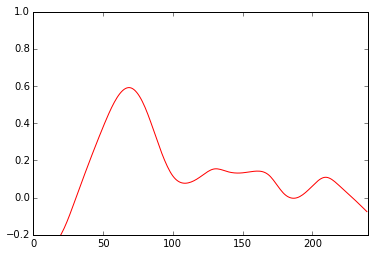

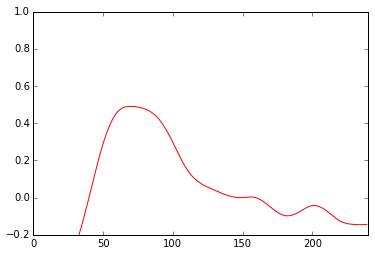

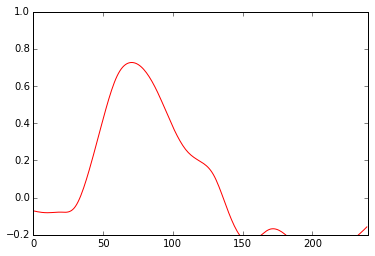

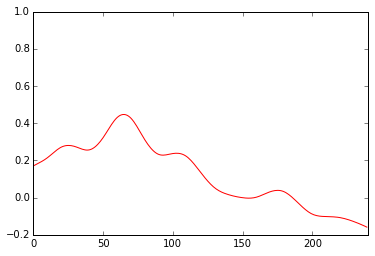

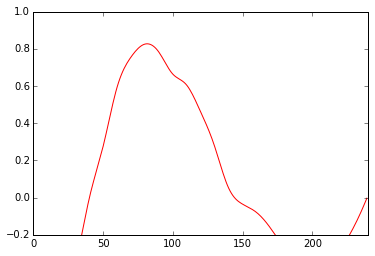

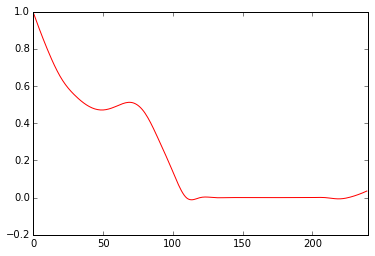

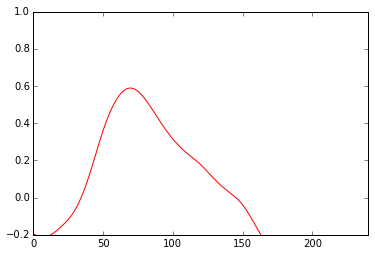

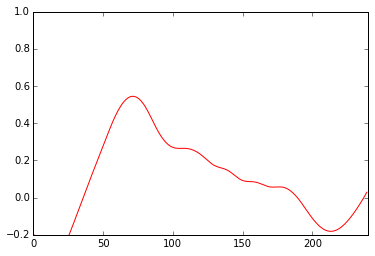

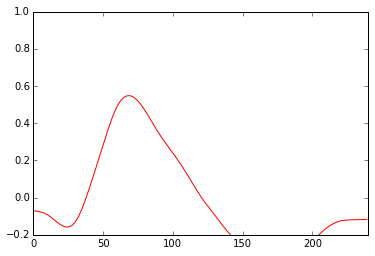

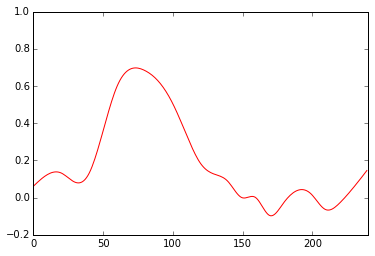

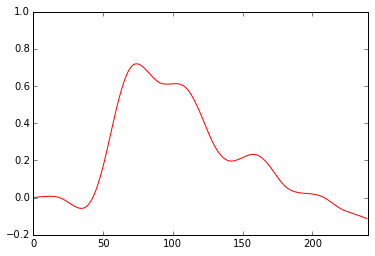

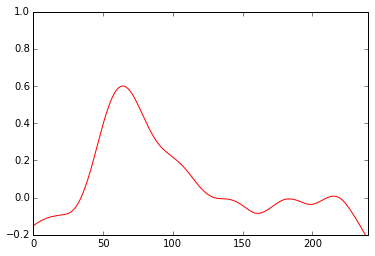

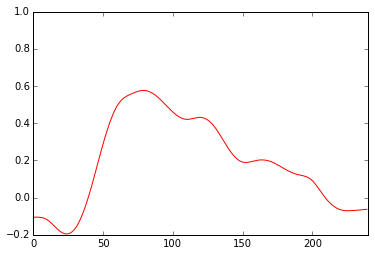

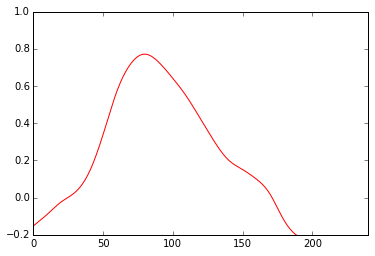

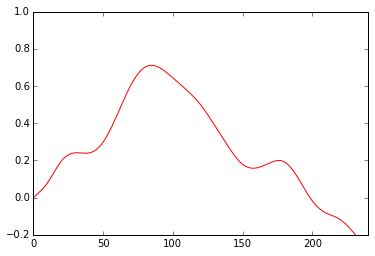

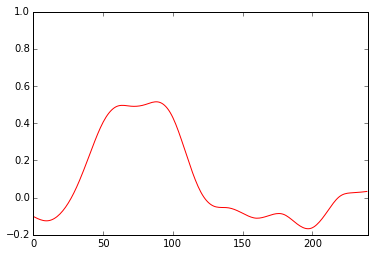

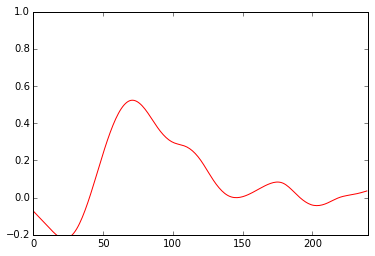

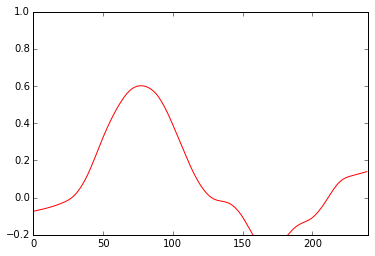

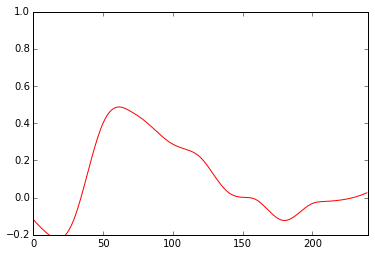

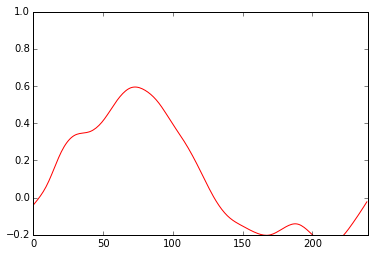

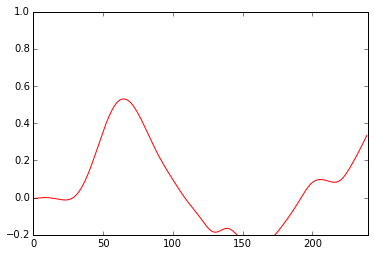

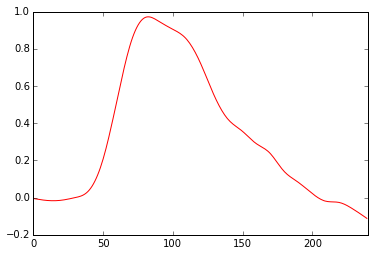

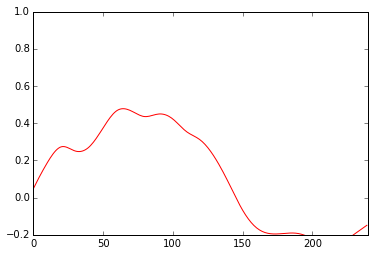

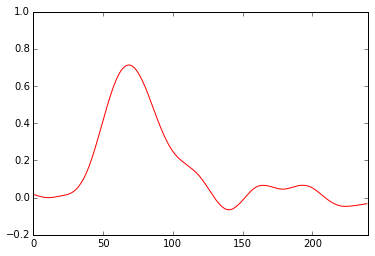

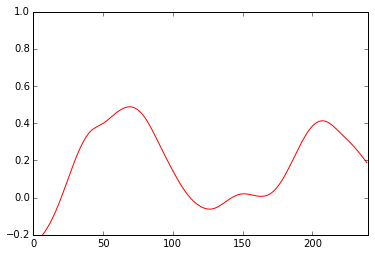

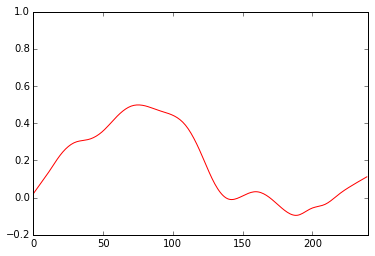

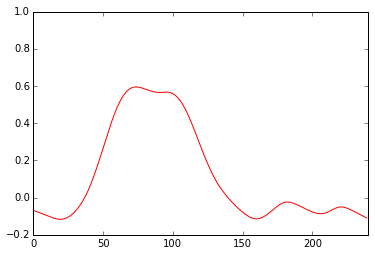

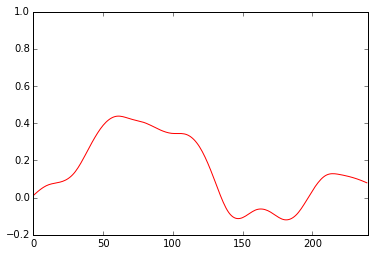

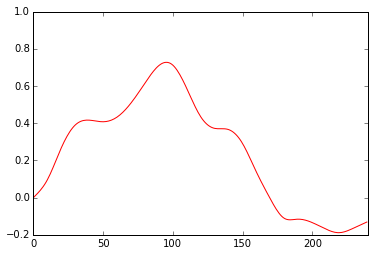

In [22]:
# Dynamic time warping.
import dtw
count = 0
label = np.zeros(1000)
for o in templates:
    count += 1
    # Iterate through all shapes and compare them with the template, the distance is the difference between template and shape.
    # If the distance is smaller then 0.03, mark the shape with  1
    for k in range(len(thresholds_norm[0,:])):
        temp = thresholds_norm[:,k]
        # The filtered "Spike" must be reshaped, otherwise the function fails
        o = o.reshape(-1,1)
        dist, cost, acc, path = dtw.dtw(o, temp, dist=lambda o, temp: np.linalg.norm(o - temp, ord=1))
        if dist < 0.03:
            label[k] = count
            plt.figure(k)
            plt.axis([0,240,-0.2,1.0])
            plt.plot(temp, color = 'blue')
        else:
            plt.figure(k)
            plt.axis([0,240,-0.2,1.0])
            plt.plot(temp, color = 'red')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
X_Reduced = pca.fit_transform(thresholds_norm)

In [ ]:
x = np.arange(1,4)
plt.scatter(x, pca.explained_variance_ratio_, linewidth = 0)